In [1]:
import numpy as np
import matplotlib

In [2]:
# you can select an alternative theme's plot style by name
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
#jtplot.style('grade3', grid=False, context = 'paper')
# jtplot.style('oceans16', grid=False, context = 'paper')
plt.rc('axes', axisbelow=True)

## PART I

In [3]:
grav=9.81; # Yes we will use SI units… this is the apparent gravity
nth=24;    # Number of directions for our discrete spectrum
nk=36;     # Number of wavenumbers : in practice we work with 
           #        spectral density in wavenumber space
XFR=1.1;   # ratio of frequencies f(i+1)/f(i) 

# Now we define our vector of discrete frequencies 
freq=0.034*np.exp(np.linspace(0,nk-1,nk)*np.log(XFR));
sig=2.*np.pi*freq;
# and corresponding wavenumbers 
k=sig**2/grav; 

# and a few more arrays to manipulate these
df=freq*(XFR-1/XFR)/2;
Cg=grav/(2*sig);      # group speed assuming deep water
dk=df*2*np.pi/Cg;
dk2d=np.tile(dk,(nth,1)).T
sig2d=np.tile(sig,(nth,1)).T
k2d=np.tile(k,(nth,1)).T
c2d=sig2d/k2d;
dkdf2d=np.tile((dk/df),(nth,1)).T

# now we define the discrete directions 
dthd=360/nth;        # direction increment in degrees
dird=np.linspace(0,(nth-1)*dthd,nth);
d2r=np.pi/180
dthr=dthd*d2r;         # direction increment in radians

# We will now also discretize the time ... 
# You can increase tmax from 12 to 96 hours ... 

tmax=48*3600;		# time at end of integration (in seconds)
dt=100;nt=int(tmax/dt+1);	# time step and number of steps

E=np.zeros((nk,nth));
allE=np.zeros((nk,nth,nt)); # stores the spectrum at all time steps
allEf=np.zeros((nk,nt));    # stores the spectrum at all time steps
Hs=np.zeros((nt,1));

# defining our winf forcing
# WARNING: when you change the wind in time, you have to move this piece 
# inside of the loop on time steps

# some parameters
rhoa=1.29;  # air density in kg/m^3
rhow=1026;  # water density in kg / m^3
Cd=0.0012;  # drag coefficient

coef1=80*(Cd*rhoa/rhow)**2/grav**2;

U10=10;
thetaw=180;
ustar=np.sqrt(Cd)*U10;           # NB: the wind stress in rhoa*ustar^2 = rhoa*Cd*U10^2
fPM=0.123*grav/(28*ustar);  # this is the Pierson-Moskowitz frequency
coswind=np.cos((dird-thetaw)*d2r);
cos2d=np.tile(np.cos((dird-thetaw)*d2r),(nk,1));

coef1=80*(Cd*rhoa/rhow)**2/grav**2;
coefSnyder=0.25*rhoa/rhow;
coefKomen=-2.36E-5;
s2PM=3.02E-4;
Sinl=np.zeros((nk,nth))
coswind_pos=coswind
coswind_pos[coswind<0]=0
# If the wind stays constant, then the linear wave growth is constant
# and can be pre-computed outside of the time loop
for ik in range(nk):
    G=np.exp(-(freq[ik]/fPM)**(-4)); #filter for linear input
    #G=1; # use G=1 to test the impact of direct input to low frequencies
    Sinl[ik,:]=coef1*sig[ik]/k2d[ik]*U10**4*coswind_pos**4*G;
    
time=np.linspace(0,dt*(nt-1),nt);
cos2d_coeff=28*ustar/c2d*cos2d-1
cos2d_coeff[cos2d_coeff<0]=0
# Loop on time steps. 
for it in range(nt-1):  
    dt=time[it+1]-time[it];
    allEf[:,it]=np.sum(E*dkdf2d,1)*dthr;
    
    Etot=np.sum(allEf[:,it]*df); 
    Eftot=np.sum(allEf[:,it]*df/freq); 
    
    fmean=np.min([freq[-1],(Etot+1E-10)/(Eftot+3E-10)]);
    kmean=(2*np.pi*fmean)**2/grav;
    s2mean=Etot*kmean**2/grav**2;
    
    Hs[it]=4*np.sqrt(Etot);
    
    Sin_Snyder=coefSnyder*cos2d_coeff;
    Sds_Komen=coefKomen*fmean*(s2mean/s2PM)**2*k2d/kmean;
    
    # Only linear growth ... 
    # E=E+Sinl*dt;
    
    diag=Sin_Snyder+Sds_Komen;
    E=E+E*diag*dt+Sinl*dt;
    
# values for last time step
allEf[:,it+1]=np.sum(E*dkdf2d,1)*dthr;
Etot=np.sum(allEf[:,it+1]*df); 
Hs[it+1]=4*np.sqrt(Etot);

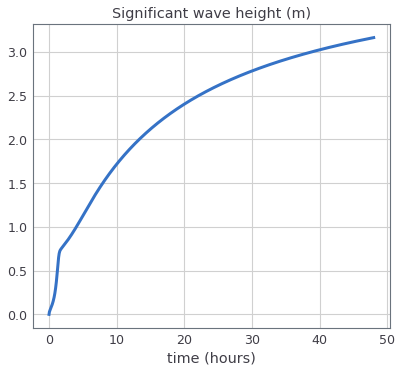

In [4]:
plt.figure(1)
plt.plot(time/3600,Hs,linewidth=3);
#set(gca,'FontSize',16,'LineWidth',1);
plt.title('Significant wave height (m)')
plt.xlabel('time (hours)')
plt.grid()

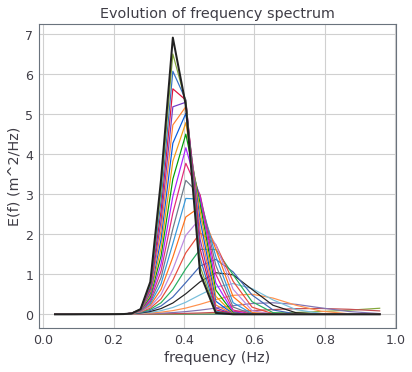

In [5]:
plt.figure(2)
plt.plot(freq,allEf[:,1::int(7200/dt)])
# set(gca,'FontSize',16,'LineWidth',1);
plt.title('Evolution of frequency spectrum')
plt.xlabel('frequency (Hz)')
plt.ylabel('E(f) (m^2/Hz)')
plt.plot(freq,allEf[:,-1],color='k',linewidth=2)
plt.grid()

/home1/datahome/sbrumer/.conda/envs/mon_env_py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home1/datahome/sbrumer/.conda/envs/mon_env_py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


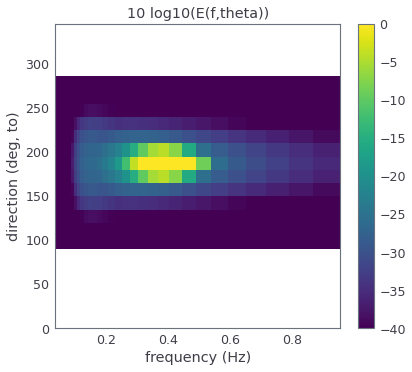

In [6]:
plt.figure(3)
plt.pcolor(freq,dird,10*np.log10(E*dkdf2d).T,vmin=-40,vmax=0)#,shading='auto');
plt.title('10 log10(E(f,theta))');
plt.xlabel('frequency (Hz)');
plt.ylabel('direction (deg, to)');
plt.colorbar();

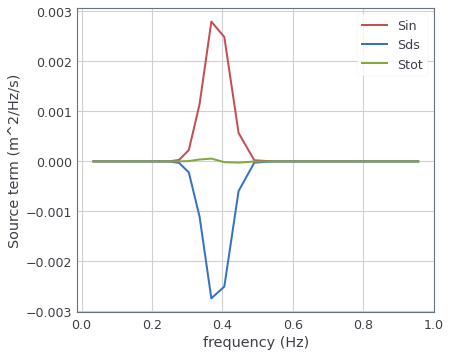

In [7]:
plt.figure(4)
sinf=np.sum(Sin_Snyder*E*dkdf2d*dthr,1);
sdsf=np.sum(Sds_Komen*E*dkdf2d*dthr,1);
plt.plot(freq,sinf,color ='r',linewidth=2,label='Sin')
plt.plot(freq,sdsf,color ='b',linewidth=2,label='Sds')
plt.plot(freq,sinf+sdsf,color ='g',linewidth=2,label='Stot')
#set(gca,'FontSize',16,'LineWidth',1);
plt.legend();
plt.xlabel('frequency (Hz)');
plt.ylabel('Source term (m^2/Hz/s)');
plt.grid()

/home1/datahome/sbrumer/.conda/envs/mon_env_py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home1/datahome/sbrumer/.conda/envs/mon_env_py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


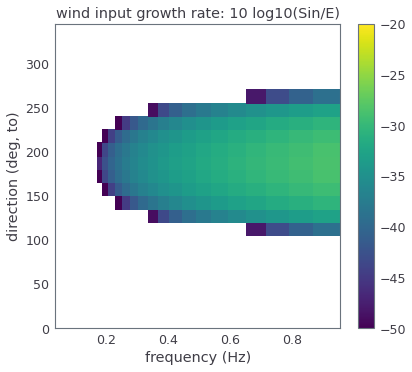

In [8]:
plt.figure(5)
plt.pcolor(freq,dird,10*np.log10(Sin_Snyder).T,vmin=-50,vmax=-20)#,shading='auto');
plt.title('wind input growth rate: 10 log10(Sin/E)');
plt.xlabel('frequency (Hz)');
plt.ylabel('direction (deg, to)');
plt.colorbar();

## PART II

In [9]:
import xarray as xr

/home1/datahome/sbrumer/.conda/envs/mon_env_py3/lib/python3.7/site-packages/distributed/utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [10]:
# defines folders and names of the different runs
LAB_DIR='/home1/datahome/sbrumer/Lab3-source-term-integration/'
RUNS = {0:{'tag':'WAM4.5','path':'ST3-Default','marker':'o'},
        1:{'tag':'T471','path':'STY-T471','marker':'s',},
        2:{'tag':'T475','path':'ST4-T475','marker':'<',},
        3:{'tag':'T700 (Romero 2019)','path':'ST4-T700','marker':'X',},  #tag2='T600h';path2='ST4-T600h';}
        4:{'tag':'T700NL2', 'path':'STYNL2','marker':'p',},
        # tag2='T705';path2='ST4-T705';
        # tag5='T702';path5='ST4-T702';
        5:{'tag':'T704','path':'ST4-T704','marker':'o',}}



nfi=5;nfip=5; 			    # number of different runs for plots
syms1=['ro','ks','b<','mx','m+'];   # symbols for plots
#syms=np.reshape(syms1,2,nfi);

name1='/ww3.P1_2000_src.nc';

# some interesting frequencies ... 

f9=0.2;
f10=0.5;
f11=0.8;
f12=0.95;

In [11]:
def HsTp_from_spectrum_windsea(E,freq,direction):
    g=9.81;
    nk=len(freq);
    nth=int(len(direction));
    dth=2*np.pi/float(nth);
    df=np.zeros((nk,));
    df[1:-1]=0.5*(freq[2:]-freq[:nk-2]);
    df[0]=freq[1]-freq[0];
    df[-1]=freq[-1]-freq[-2];
    Ef=np.sum(E,1)*dth;
    overlap=dth*np.sum(E[:,:int(nth/2)]*E[:,int(nth/2):],1)/(Ef**2);
    #[Emax,imax]=max(Ef);
    imax = np.argmax(Ef)
    fp=np.sum(Ef[np.max([imax-1,1]):np.min([imax+1,nk])]*freq[np.max([imax-1,1]):np.min([imax+1,nk])])
    /np.sum(Ef[np.max([imax-1,1]):np.min([imax+1,nk])]);
    Etot=np.dot(Ef,df);
    km=Ef*df*freq/Etot*(2*np.pi/np.sqrt(g));
    Hm0=4*np.sqrt(Etot);
    Tp1=1/fp;
    Etot=np.dot(Ef[np.argwhere(freq>.068)].squeeze(),df[np.argwhere(freq>.068)].squeeze())
    Hsws=4*np.sqrt(Etot);
        
    return Hm0,Tp1,imax,km,Ef,overlap,df,Hsws
 

In [12]:
%%capture out
fig={}; ax={}
for fign in range(13):
    fig[fign],ax[fign]=plt.subplots()
    ax[fign].grid()
# loop on the model runs 
for fn in range(nfi):
    file_path=LAB_DIR + RUNS[fn]['path']+name1
    f = xr.open_dataset(file_path)

    # Now reads spectrum and source terms from the current model run
    dates=time
    k=((2*np.pi*f.frequency)**2/grav); # deep water only
    # k=dispNewtonTH(freq,100); # this would be some known water depth ... 
    nk=len(f.frequency)
    nth=len(f.direction)
    nt=len(f.time)

    dth=2*np.pi/nth;
    cos2=np.tile(np.cos(f.direction*np.pi/180)**2,(nk,1));
    sin2=np.tile(np.sin(f.direction*np.pi/180)**2,(nk,1));

    times=(f.time-f.time[0])/ np.timedelta64(1, 'h')
    f.coords['TIME'] = ('time',times)
    f = f.swap_dims({'time':'TIME'})
    # Reads other parameters from the model run (wind forcing, wind stress ...) 
    filename=LAB_DIR + RUNS[fn]['path']+ '/ww3.200001.nc'
    field = xr.open_dataset(filename).isel(latitude=0,longitude=0)
    times=(field.time-field.time[0])/ np.timedelta64(1, 'h')
    field.coords['TIME'] = ('time',times)
    field = field.swap_dims({'time':'TIME'})
    varmss1='mssu';  # NB: these mss (as of today when no tail is added) can also be computed from the spectrum
    varmss2='mssc';
    field['mss2']=(field[varmss1]+field[varmss2])
    field['wnd2']=(np.sqrt(field.uwnd**2+field.vwnd**2))
    
    kwarg={'label':RUNS[fn]['tag'],'marker':RUNS[fn]['marker']}

    field.hs.plot(ax = ax[0],**kwarg)
    field.mss2.plot(ax = ax[1],**kwarg)
    (field.uust**2).plot(ax = ax[2],**kwarg)
    (field.mssc/field.mssu).plot(ax = ax[3],**kwarg)
    
    
    Hm0,Tp1,imax,km,Ef,overlap,df,Hsws=HsTp_from_spectrum_windsea(f.efth.isel(TIME=48).squeeze().values,f.frequency.values,f.direction.values)
    Tp=np.zeros(len(f.TIME))
    for t in range(len(f.TIME)):
        _,Tp[t],_,_,_,_,_,_,=HsTp_from_spectrum_windsea(f.efth.isel(TIME=t).squeeze().values,f.frequency.values,f.direction.values)
    ax[4].plot(f.frequency.values,Ef,**kwarg)
    ax[5].plot(f.frequency.values,Ef*f.frequency.values**5,**kwarg)
    ax[6].plot(f.frequency.values,Ef*f.frequency.values**4,**kwarg)
    # fix Tp
    (field['wnd2']/9.81*Tp/(2*np.pi)).plot(ax = ax[7],**kwarg)
    ax[12].plot(f.frequency.values,overlap,linestyle = 'None',**kwarg)
    freq = f.frequency.values
    dirs= f.direction.values
    I=np.argwhere(freq>f9)
    ax[9].plot(dirs,f.efth.isel(TIME=48).squeeze()[I[0],:].squeeze(),linestyle = 'None',**kwarg)
    I=np.argwhere(freq>f10)
    ax[10].plot(dirs,f.efth.isel(TIME=48).squeeze()[I[0],:].squeeze(),linestyle = 'None',**kwarg)
    I=np.argwhere(freq>f11)
    ax[11].plot(dirs,f.efth.isel(TIME=48).squeeze()[I[0],:].squeeze(),linestyle = 'None',**kwarg)
    I=np.argwhere(freq>f10)
    ax[10].plot(dirs,f.efth.isel(TIME=48).squeeze()[I[0],:].squeeze(),linestyle = 'None',**kwarg)

    
    
for fign in range(13):
    ax[fign].legend()
    ax[fign].set_title('')
    if fign<4 or fign == 7:
        ax[fign].set_xlim(0,48)
        ax[fign].set_xlabel('Duration (hours)')
    if fign>7:
        ax[fign].set_xlabel('frequency (Hz)')
        ax[fign].set_ylabel('Opposition integral I(f)')
ax[0].set_ylabel('Hs (m)')
ax[0].set_ylim([0,2.8])

ax[1].set_ylabel('$mss_{f< 1 Hz}$')
ax[1].set_ylim([0, 0.025])

ax[2].set_ylabel('$C_D$')


ax[3].set_ylabel('mss2/mss1')
ax[3].set_ylim([0, 1])

ax[4].set_xlabel('frequency (Hz)')
ax[4].set_ylabel('$E(f)$ (m$^2$/Hz)')
ax[4].loglog((freq),(freq**-4)/1000,'k-','linewidth',1)
ax[4].loglog((freq),(freq**-5)/1000,'k-','linewidth',1)
ax[4].set_ylim([0.001, 10])

ax[5].set_xlabel('frequency (Hz)')
ax[5].set_ylabel(r'$E(f) \times f^5$ (m$^2$ )')

ax[6].set_xlabel('frequency (Hz)')
ax[6].set_ylabel('$E(f) \times f^4$ (m$^2$ )')


ax[7].set_ylabel('Age')

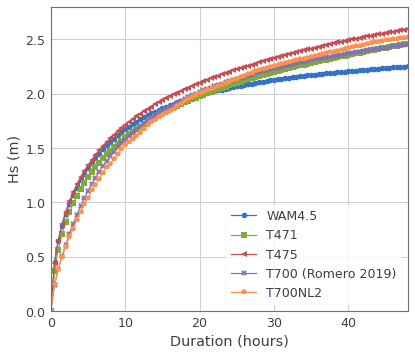

In [13]:
fig[0]

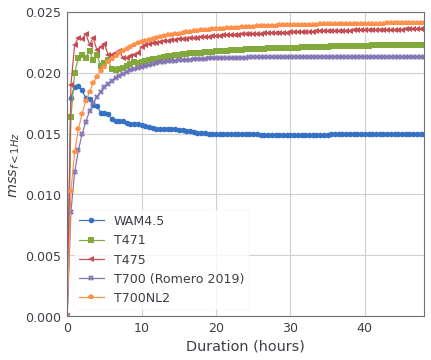

In [14]:
fig[1]

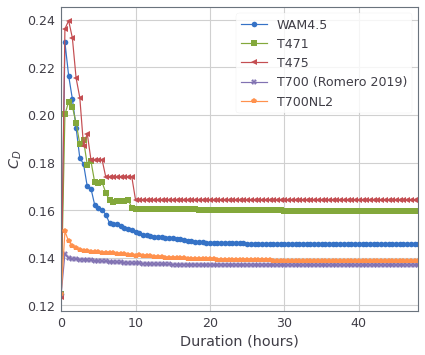

In [15]:
fig[2]

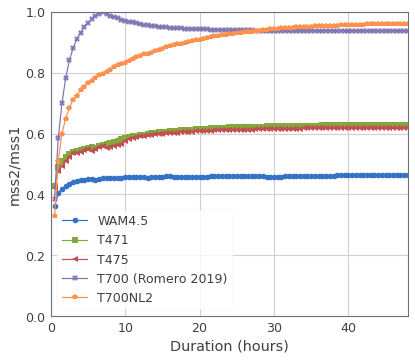

In [16]:
fig[3]

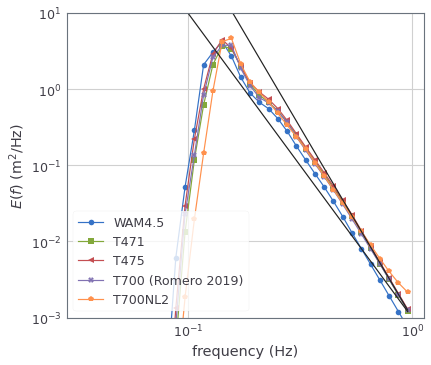

In [17]:
fig[4]

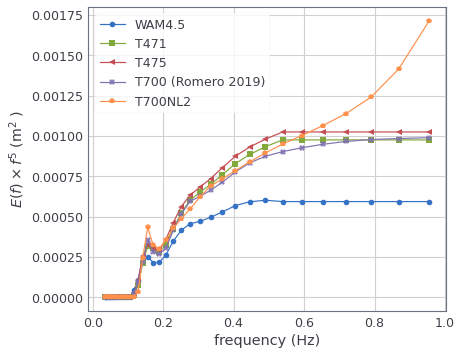

In [18]:
fig[5]

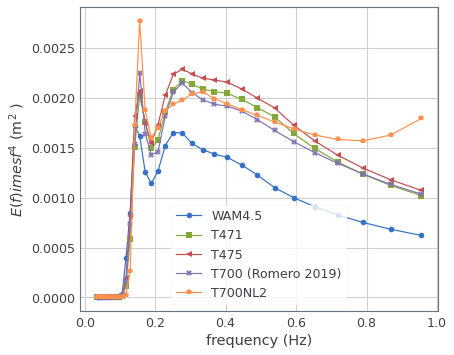

In [19]:
fig[6]

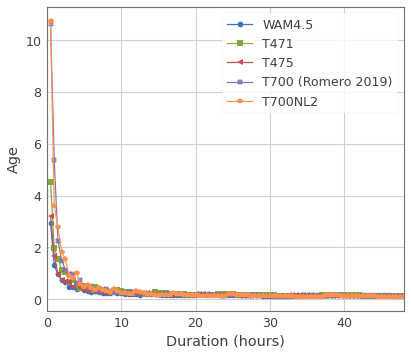

In [20]:
fig[7]

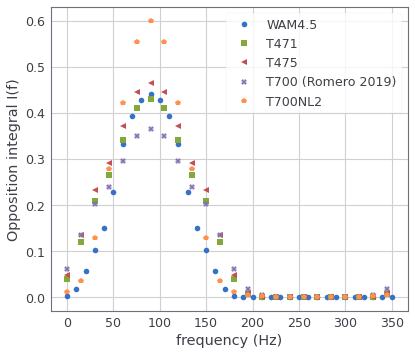

In [21]:
fig[9]

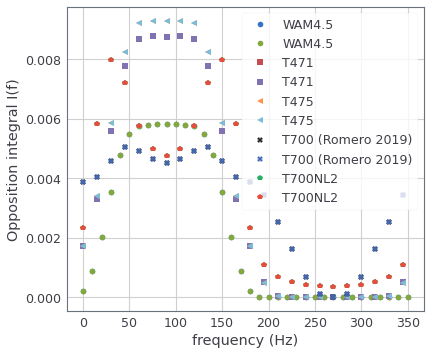

In [22]:
fig[10]

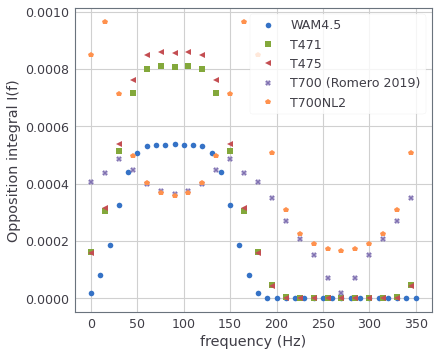

In [23]:
fig[11]

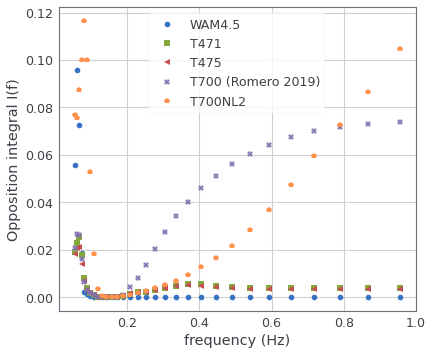

In [24]:
fig[12]